In [1]:
import mne
import matplotlib.pyplot as plt

In [2]:
SUB_ID = '04'
RAW_FILE_PATH = f'data/openmiir/eeg/mne/P{SUB_ID}-raw.fif'
ICA_FILE_PATH = f'data/openmiir/eeg/preprocessing/ica/P{SUB_ID}-100p_64c-ica.fif'

In [3]:
raw = mne.io.read_raw_fif(RAW_FILE_PATH)

Opening raw data file data/openmiir/eeg/mne/P04-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2480032 =      0.000 ...  4843.812 secs
Ready.


# Fix load_ica

In [4]:
from mne.io import fiff_open
from mne.io.meas_info import read_meas_info

In [5]:
fid, tree, _ = fiff_open(ICA_FILE_PATH)
info, _ = read_meas_info(fid, tree, clean_bads=True)

Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle


In [6]:
from mne.io.tree import dir_tree_find

In [7]:
from mne.io.constants import FIFF

In [8]:
from mne.io.tag import read_tag

In [9]:
ica_data = dir_tree_find(tree, FIFF.FIFFB_MNE_ICA)
if len(ica_data) == 0:
    ica_data = dir_tree_find(tree, 123)  # Constant 123 Used before v 0.11
    if len(ica_data) == 0:
        fid.close()
        raise ValueError("Could not find ICA data")

In [10]:
ica_data

[{'block': 123,
  'id': None,
  'parent_id': None,
  'nent': 10,
  'nchild': 0,
  'directory': [<Tag | kind 3601 - type 10 - size 96 - next 0 - pos 8196 - data None>,
   <Tag | kind 3502 - type 10 - size 220 - next 0 - pos 8308 - data None>,
   <Tag | kind 3601 - type 10 - size 96 - next 0 - pos 8544 - data None>,
   <Tag | kind 3609 - type 10 - size 17 - next 0 - pos 8656 - data None>,
   <Tag | kind 3603 - type 1073741829 - size 516 - next 0 - pos 8689 - data None>,
   <Tag | kind 3604 - type 1073741829 - size 31764 - next 0 - pos 9221 - data None>,
   <Tag | kind 3606 - type 1073741829 - size 512 - next 0 - pos 41001 - data None>,
   <Tag | kind 3605 - type 1073741829 - size 512 - next 0 - pos 41529 - data None>,
   <Tag | kind 3607 - type 1073741829 - size 31764 - next 0 - pos 42057 - data None>,
   <Tag | kind 3608 - type 3 - size 8 - next 0 - pos 73837 - data None>],
  'children': []}]

In [11]:
my_ica_data = ica_data[0]
ica_reject = None
for d in my_ica_data["directory"]:
    kind = d.kind
    pos = d.pos
    if kind == FIFF.FIFF_MNE_ICA_INTERFACE_PARAMS:
        tag = read_tag(fid, pos)
        ica_init = tag.data
    elif kind == FIFF.FIFF_MNE_ROW_NAMES:
        tag = read_tag(fid, pos)
        ch_names = tag.data
    elif kind == FIFF.FIFF_MNE_ICA_WHITENER:
        tag = read_tag(fid, pos)
        pre_whitener = tag.data
    elif kind == FIFF.FIFF_MNE_ICA_PCA_COMPONENTS:
        tag = read_tag(fid, pos)
        pca_components = tag.data
    elif kind == FIFF.FIFF_MNE_ICA_PCA_EXPLAINED_VAR:
        tag = read_tag(fid, pos)
        pca_explained_variance = tag.data
    elif kind == FIFF.FIFF_MNE_ICA_PCA_MEAN:
        tag = read_tag(fid, pos)
        pca_mean = tag.data
    elif kind == FIFF.FIFF_MNE_ICA_MATRIX:
        tag = read_tag(fid, pos)
        unmixing_matrix = tag.data
    elif kind == FIFF.FIFF_MNE_ICA_BADS:
        tag = read_tag(fid, pos)
        exclude = tag.data
    elif kind == FIFF.FIFF_MNE_ICA_MISC_PARAMS:
        tag = read_tag(fid, pos)
        ica_misc = tag.data
    elif kind == FIFF.FIFF_MNE_EPOCHS_REJECT_FLAT:
        tag = read_tag(fid, pos)
        ica_reject = json.loads(tag.data)["reject"]

fid.close()

In [12]:
import json

In [13]:
def _deserialize(str_, outer_sep=";", inner_sep=":"):
    """Aux Function."""
    out = {}
    for mapping in str_.split(outer_sep):
        k, v = mapping.split(inner_sep, 1)
        out[k] = json.loads(v)
    return out

In [14]:
ica_init, ica_misc = [_deserialize(k) for k in (ica_init, ica_misc)]
n_pca_components = ica_init.pop("n_pca_components")
current_fit = ica_init.pop("current_fit")
max_pca_components = ica_init.pop("max_pca_components")
method = ica_misc.get("method", "fastica")

In [15]:
_KNOWN_ICA_METHODS = ("fastica", "infomax", "picard")

In [16]:
from inspect import signature

In [17]:
if method in _KNOWN_ICA_METHODS:
    ica_init["method"] = method

print("Now restoring ICA solution ...")

# make sure dtypes are np.float64 to satisfy fast_dot
def f(x):
    return x.astype(np.float64)

ica_init = {
    k: v for k, v in ica_init.items() if k in signature(mne.preprocessing.ICA.__init__).parameters
}

Now restoring ICA solution ...


In [18]:
ica_init['method'] = 'infomax'

In [19]:
ica_init['fit_params'] = dict(extended=True)

In [20]:
ica_init['n_components'] = 61

In [21]:
ica = mne.preprocessing.ICA(**ica_init)

In [22]:
import numpy as np

In [23]:
ica.current_fit = current_fit
ica.ch_names = ch_names.split(":")
if n_pca_components is not None and not isinstance(n_pca_components, int_like):
    n_pca_components = np.float64(n_pca_components)
ica.n_pca_components = n_pca_components
ica.pre_whitener_ = f(pre_whitener)
ica.pca_mean_ = f(pca_mean)
ica.pca_components_ = f(pca_components)
ica.n_components_ = unmixing_matrix.shape[0]
ica._max_pca_components = max_pca_components
ica._update_ica_names()
ica.pca_explained_variance_ = f(pca_explained_variance)
ica.unmixing_matrix_ = f(unmixing_matrix)
ica._update_mixing_matrix()
ica.exclude = [] if exclude is None else list(exclude)
ica.info = info
if "n_samples_" in ica_misc:
    ica.n_samples_ = ica_misc["n_samples_"]
if "labels_" in ica_misc:
    labels_ = ica_misc["labels_"]
    if labels_ is not None:
        ica.labels_ = labels_
if "method" in ica_misc:
    ica.method = ica_misc["method"]
if "n_iter_" in ica_misc:
    ica.n_iter_ = ica_misc["n_iter_"]
if "fit_params" in ica_misc:
    ica.fit_params = ica_misc["fit_params"]
ica.reject_ = ica_reject

In [24]:
ica

Method,infomax
Fit,None iterations on epochs (529100 samples)
ICA components,63
Available PCA components,63
Channel types,eeg
ICA components marked for exclusion,ICA000ICA002


In [25]:
raw.info

<Info | 11 non-empty values
 bads: 1 items (T8)
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 4 EOG, 1 Stimulus
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2015-01-30 14:26:12 UTC
 meas_id: 4 items (dict)
 nchan: 69
 projs: Average EEG reference: off
 sfreq: 512.0 Hz
>

Using matplotlib as 2D backend.


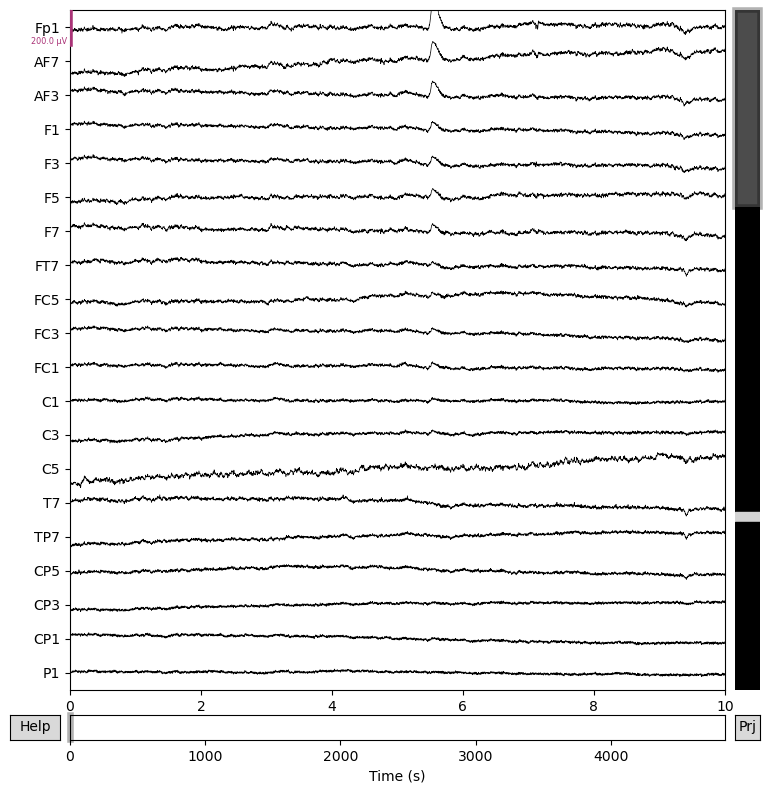

In [26]:
%matplotlib inline
_ = raw.plot(scalings='1e-4')

In [27]:
preprocessed = raw.copy()
ica.apply(preprocessed.load_data())

Reading 0 ... 2480032  =      0.000 ...  4843.812 secs...
Applying ICA to Raw instance
    Transforming to ICA space (63 components)
    Zeroing out 2 ICA components
    Projecting back using 63 PCA components


<Raw | P04-raw.fif, 69 x 2480033 (4843.8 s), ~1.28 GB, data loaded>

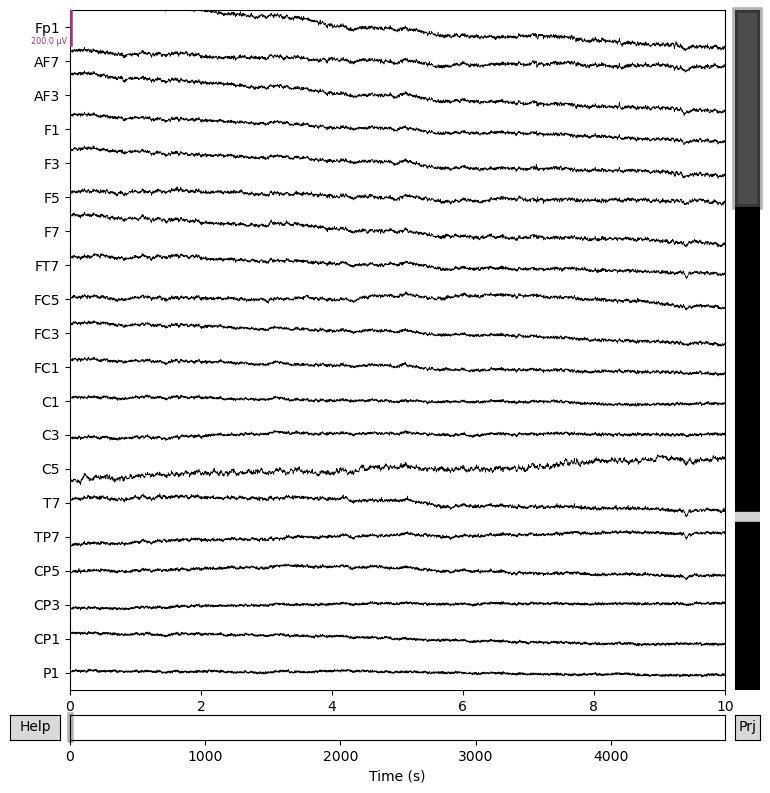

In [28]:
%matplotlib inline
_ = preprocessed.plot(scalings='1e-4')

540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2000 2001]


C:\Users\Paul\AppData\Local\Temp\ipykernel_1564\1785152826.py:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  plot = mne.viz.plot_events(mne.find_events(raw))


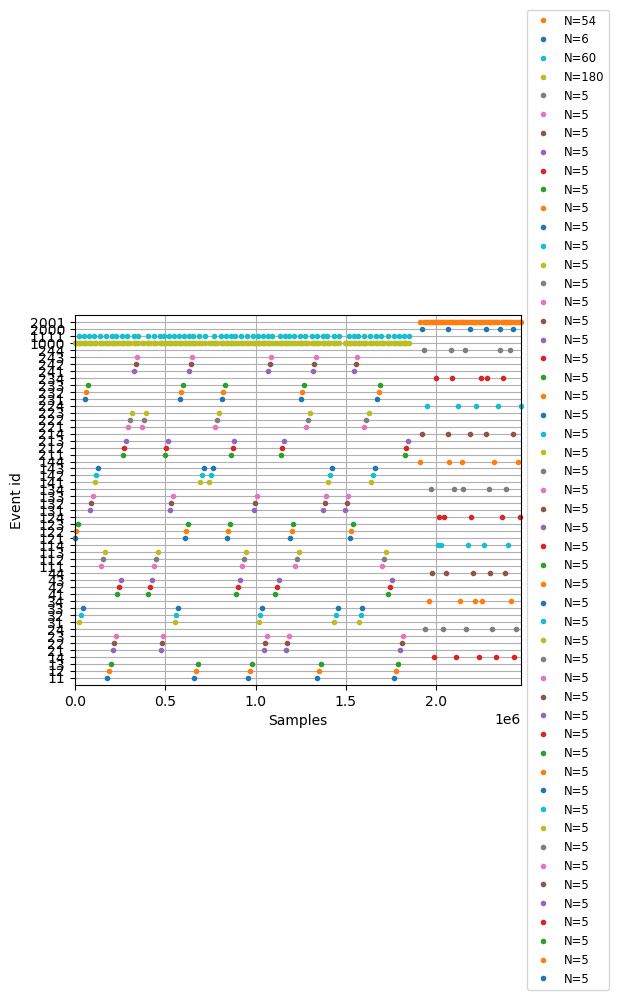

In [31]:
%matplotlib inline
plot = mne.viz.plot_events(mne.find_events(raw))